# AxiScan Example

In this notebook we provide a brief example of what can be done with the AxiScan code. In detail we will show 1. how to generate Monte Carlo data; 2. search for a signal and set limits using such data; 3. perform specific parameter scans.

In [1]:
# Import relevant modules

import os
import numpy as np
import scipy.stats
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = 15, 10 # default figure size
import pymultinest
import corner

from AxiScan import mc_gen # MC Generation
from AxiScan import scan # Data Analysis
import analysis_utilities as au # Convenient Utility Methods

# 1: Generate a Monte Carlo Dataset

## Set the Parameters

First we generate Monte Carlo data for a scenario in which the majority of the dark matter is contained within a bulk halo following the Standard Halo Model parameters with a subdominant fraction contained within the Sagitarrius Stream. Although we have chosen to illustrate the analysis with a large signal strength, this can be easily adjusted. 

To generate the data we need to seed an instance (`generator`) of the Generator class in `mc_gen` with arguments detailed below. Data on the $i^\text{th}$ day of data collection is generated by calling `generator.makePSD(i)`. The arguments for the Generator class are 

| Argument | Purpose |
| ------------- | ------------- |
| ma | ma/2pi is the axion mass [Hz] |
| A | Proxy for the axion-photon coupling,  $A \propto g_{a \gamma \gamma}^2$ |
| lambdaB | Mean expected background Power Spectral Density |
| v0_Halo | Velocity dispersion of the bulk halo [km/s] |
| vDotMag_Halo | Speed of the sun with respect to the bulk halo [km/s]|
| alpha_Halo | Bulk halo annual modulation scale, $\alpha \in [0, 1]$|
| tbar_Halo | Date parameter for the bulk halo annual modultion [days] |
| v0_Sub | Speed dispersion of the substructure halo [km/s] |
| vDotMag_Sub | Speed of the sun with respect to the substructure halo [km/s]|
| alpha_Sub | Substructure halo annual modulation scale, $\alpha \in [0, 1]$|
| tbar_Sub | Date parameter for the substructure halo annual modultion [days] |
| frac_Sub | Fraction of the axion DM in the substructure |
| freqs | Array of frequencies to calculate the PSD at [Hz] |

The code generates data in the form of Power Spectral Densities (PSD).

In [2]:
# Axion Parameters
ma = 2*np.pi*5.5e5 # axion mass [Hz]
A = 600. # axion signal strength [1/eV]

# Background
lambdaB = 1.6e5 # typical SQUID noise [1/eV]

# Bulk SHM Parameters
v0_Halo = 220.0
vDotMag_Halo = 232.36
alpha_Halo = .49
tbar_Halo = 72.40

# Sagitarrius Stream Parameters
v0_Sub = 10.0
vDotMag_Sub = 418.815
alpha_Sub = .65903
tbar_Sub = 279.51
frac_Sub = 0.05

# Data Output Size
freqs = np.linspace(.99999, 1.00001, 500)*5.5e5
PSD_Data = np.zeros((365, len(freqs)))

collectionTime = 1/(freqs[1] - freqs[0])
stacked_per_day = 86400 / collectionTime
num_stacked = 365*stacked_per_day # 365 to obtain a year of data

# Initiate the data generator
generator = mc_gen.Generator(ma, A, lambdaB, v0_Halo, vDotMag_Halo, alpha_Halo, tbar_Halo,
                             v0_Sub, vDotMag_Sub, alpha_Sub, tbar_Sub, frac_Sub, freqs)

## Generate the Data

Here we fill the `PSD_Data` array with each day of collected data. Data is generated assuming that that the entire 24 hours is used for data collection. If the collection time $T$ as inferred from the user-defined frequency resolution in `freqs` is less than 24 hours, then the data generated for each day is constructed as 24 hours / $T$ stacked copies of data collections of duration $T$. 

We then stack data over the course of the year. The data stacked on the duration of a year is used for simple scans for an axion signal. The unstacked data can be used for more detailed parameter scans, as shown further below.

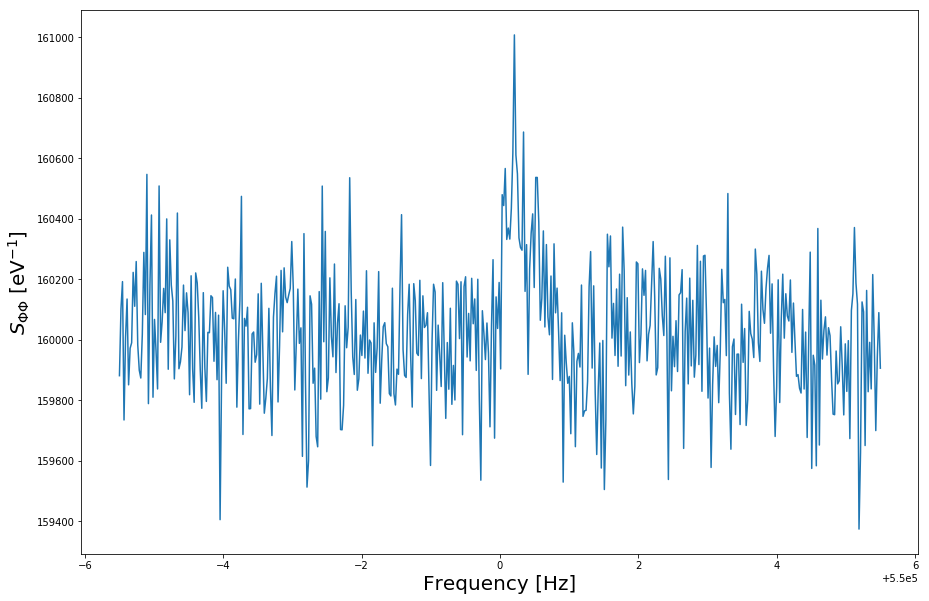

In [3]:
# Fill the PSD_Data array day by day
for i in range(365):
    PSD_Data[i] = np.array(generator.makePSD(i))

# Average over the days in the PSD_Data array for the simple scan
Stacked_PSD_Data = np.mean(PSD_Data, axis = 0)

plt.plot(freqs, Stacked_PSD_Data)
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel(r'$S_{\Phi\Phi}$ [eV$^{-1}$]', fontsize=20)
plt.show()

In the figure we can see that near the axion mass in the center of the dataset, there is an excess corresponding to the signal. We will show how to extract this below.

# 2: The Simple Scan

## Calculating the Test Statistic

Next we analyze the Monte Carlo data we just created when stacked over the duration of a year. In this analysis, we only scan over values of $A$ and $m_a$, and we will assume the Axion DM to follow a bulk Standard Halo Model profile with no substructure present. As we will see, ignoring substructure will not prevent us from seeing evidence of a signal. These steps can be repeated on real data.

The anlysis is performed using `scan.TS_Scan`, which has the following arguments:

| Argument | Purpose |
| ------------- | ------------- |
| Stacked_PSD_Data | Array of PSD data associated with the measurements when stacked over the duration of a year|
| freqs | Array of frequencies associated with the data points [Hz] |
|mass_TestSet | Range of axion masses scanned for in the analysis|
| A_TestSet| Range of values of the A parameter scanned for at each mass| 
| lambdaB | Mean expected background Power Spectral Density | 
| v0_Exp | Expected value of the SHM velocity dispersion [km/s]|
| vObs_Exp | Expected value of the sun's speed with respect to the bulk SHM Halo [km/s]|
| num_stacked | Total number of collections of duration T contained in the stacked data |

The output of `scan.TS_Scan` is `TS_Array`, the value of the test statistic TS($m_a$, $A$) at each value of $ma$ and $A$ in `mass_TestSet` and `A_TestSet`.

## Defining the Scan Parameters

Since we expect to be searching for a bulk SHM distribution, we take SHM parameters `v0_Exp = 220.0` and `vObs_Exp = 232.36`. 

The set of masses in `mass_TestSet` is taken to be points on a log-spaced grid beginning at the mass corresponding to the minimum frequency for which we have data with a spacing factor of `1 + v0_Exp**2 /(2 c**2)`.

The set of $A$ in `A_TestSet` is determined by the necessary value of $A$ of an injected signal expected to produce a 5$\sigma$ detection. At a given mass-point, this value of A can be computed using (57) and (60) in the associated paper. To ensure a sufficiently large range, we compute the maximum value of such an $A$ over all mass, denoting this `A_max`. Then at each mass-point, we scan over values `-A_max` to `5 * A_max`.

In [4]:
# Expected Parameters
v0_Exp = 220.0
vObs_Exp = 232.36

# Construct the range of masses to scan over
# below do not go all the way to freqs[-1] as there are insufficient frequencies to resolve that mass
c = 299798.452 # speed of light [km/s]
N_testMass = int(np.log(freqs[-10] / freqs[0])  / np.log(1. + v0_Exp**2. / 2. / c**2.))
mass_TestSet = (freqs[0]*(1. + v0_Exp**2. / 2. / c**2.)**np.arange(N_testMass) * 2*np.pi)

# Construct the range of signal strengths to scan over
Sigma_A = au.getSigma_A(mass_TestSet, 365, 86400, v0_Exp, vObs_Exp, lambdaB)
N_indMasses = 4 * c**2 / (3 * v0_Exp**2) * np.log(np.amax(freqs)/np.amin(freqs))
TS_Thresh = scipy.stats.norm.ppf(1 - (1-scipy.stats.norm.cdf(5))/N_indMasses)**2
detection_Threshold = np.sqrt(TS_Thresh)*Sigma_A

A_TestSet = np.linspace(-1.0, 5.0, 501)*np.amax(detection_Threshold)

# Calculate the TS values
TS_Array = np.array(scan.TS_Scan(Stacked_PSD_Data, freqs, mass_TestSet, A_TestSet, 
                                 lambdaB, v0_Exp, vObs_Exp, num_stacked))

## Extracting Scan Values and Limits

Now that we have obtained `TS_Array`, we can extract our maximum-likelihood estimates and the 95% limits of $A$ at each $m_a$. 

At a given $m_a$, the maximum-likelihood estimate of $A$ is given by 
\begin{equation}
\hat A = \text{argmax}_{A} \text{TS}(m_a, A)
\end{equation}

At a given $m_a$, the 95% limit on $A$ is given by solving
\begin{equation}
\text{TS}(m_a, A_{95\%}) - \text{TS}(m_A, \hat A) = 2.71, \qquad A_{95\%} \geq \hat A
\end{equation}

In [5]:
A_Limits = np.zeros(mass_TestSet.shape) # The expected 95% constraint
A_Scans = np.zeros((mass_TestSet.shape)) # The TS maximizing value

for i in range(len(A_Limits)):
    # TS maximizing value
    A_Scans[i] = A_TestSet[np.argmax(TS_Array[i])]
    
    # Extracting the 95% constraint by a shift in the TS of 2.71
    temp = np.copy(TS_Array[i])
    temp[0:np.nanargmax(temp)] = float('nan')
    temp -= np.nanmax(temp)
    A_Limits[i] = A_TestSet[np.nanargmin(np.abs(temp+2.706))]
    
# We use power constrained limits, so we cannot set a limit stronger than the 1 sigma downward fluctuation
A_Limits = np.maximum(A_Limits, au.zScore(-1)*Sigma_A)

# Ensure A>0 in the reported best fit value
A_Scans = np.maximum(0, A_Scans)

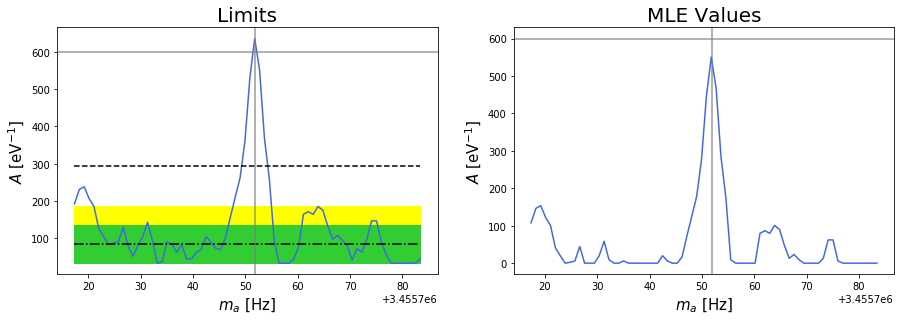

In [6]:
plt.subplot(2, 2, 1)
plt.title('Limits', size = 20)
plt.plot(mass_TestSet, A_Limits, c='royalblue')
plt.fill_between(mass_TestSet, au.zScore(-1)*Sigma_A, au.zScore(2)*Sigma_A, color = 'yellow')
plt.plot(mass_TestSet, au.zScore(0)*Sigma_A, c='black',ls='-.')
plt.plot(mass_TestSet, detection_Threshold, c='black', ls='--')
plt.fill_between(mass_TestSet, au.zScore(-1)*Sigma_A, au.zScore(1)*Sigma_A, color = 'limegreen')
plt.axvline(x=ma, c = 'gray',alpha=0.8)
plt.axhline(y=A, c = 'gray',alpha=0.8)
plt.xlabel(r'$m_a$ [Hz]', fontsize=15)
plt.ylabel(r'$A$ [eV$^{-1}$]', fontsize=15)

plt.subplot(2, 2, 2)
plt.title('MLE Values', size = 20)
plt.plot(mass_TestSet, A_Scans, c='royalblue')
plt.axvline(x=ma, c = 'gray',alpha=0.8)
plt.axhline(y=A, c = 'gray',alpha=0.8)
plt.xlabel(r'$m_a$ [Hz]', fontsize=15)
plt.ylabel(r'$A$ [eV$^{-1}$]', fontsize=15)
plt.show()

Above, we plot the results of the simple scan for an axion signal. In the left panel, we plot the resulting 95% constraints (solid blue) against the expected 95% constraints (dot dashed black) and 1$\sigma$ (green) and 2$\sigma$ (yellow) containment determined by the Asimov dataset according to (56) of the associated paper. We also show the 5$\sigma$ detection threshold. In the right panel, we plot at each mass-point the MLE of $A$ (solid blue).

In both panels the gray lines indicate the injected axion mass and signal strength $A$. On the left we see we cannot rule out the injected value with our limit, whilst on the right we see we can recover the values.

# 3: The MultiNest Scan

Now that we have discovered a well-localized axion signal, we proceed to perform a MultiNest Scan over the data stacked at the level of a day. This will allow us to perform more detailed analysis of the signal parameters. For example, a MultiNest scan could be used to gain a more accurate estimate of $A$ or $m_a$, to study the annual modulation parameters, or to search for substructure. With sufficient computational resources, these could all be accomplished simultaneously. 

In the example below, we will perform a very basic MultiNest scan to gain a more accurate estimate of the signal strength, $A$, under the assumption that all other signal parameters are known with perfect accuracy. We will then do the same for the SHM parameters $\alpha$ and $\bar{t}$. In order to determine these last two accurately we need a brighter signal than the one used above, so we will increase $A$ and also turn of the Sagittarius stream for simplicity.

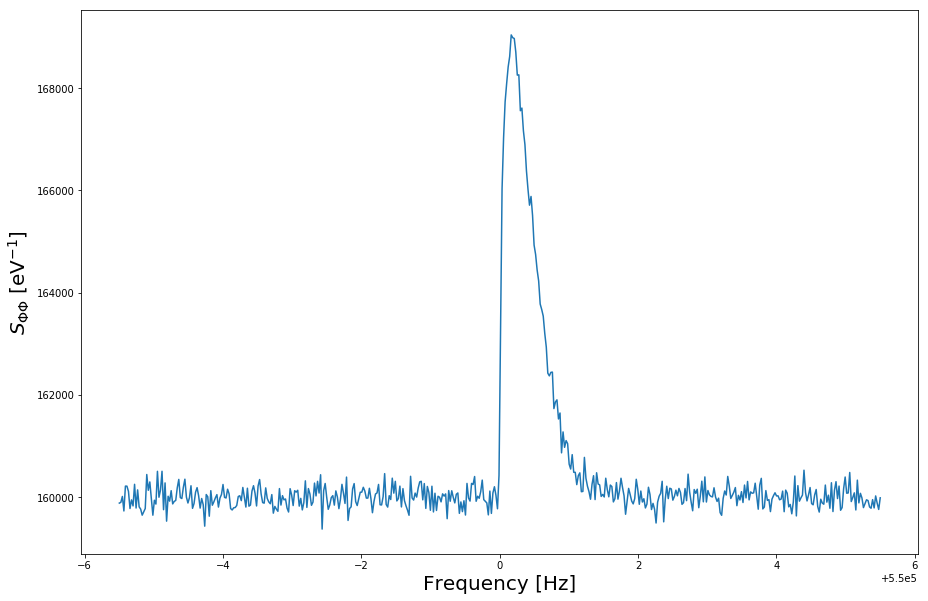

In [7]:
# Regenerate Monte Carlo Data
A = 10000.0 # larger signal strength
frac_Sub = 0.0 # turn off substructure

generator = mc_gen.Generator(ma, A, lambdaB, v0_Halo, vDotMag_Halo, alpha_Halo, tbar_Halo,
                             v0_Sub, vDotMag_Sub, alpha_Sub, tbar_Sub, frac_Sub, freqs)

PSD_Data = np.zeros((365, len(freqs)))
for i in range(365):
    PSD_Data[i] = np.array(generator.makePSD(i))
    
    
# Plot the stacked data
plt.plot(freqs, np.mean(PSD_Data, axis = 0))
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel(r'$S_{\Phi\Phi}$ [eV$^{-1}$]', fontsize=20)
plt.show()

The plot above makes it clear we are now looking at a much brighter signal. As mentioned, we will analyze this with MultiNest and so we first set up the details of the scan.

In [8]:
# Basic Settings
nlive = 500
chains_dir = os.getcwd() + '/chains/'
if not os.path.exists(chains_dir):
    os.makedirs(chains_dir)

pymultinest_options = {'importance_nested_sampling': False,
                        'resume': False, 'verbose': True,
                        'sampling_efficiency': 'model',
                        'init_MPI': False, 'evidence_tolerance': 0.5,
                        'const_efficiency_mode': False}

Using these parameters we will now scan for $A$, $\alpha$, and $\bar{t}$ individually. Note that these scans can take a few minutes each to complete.

## Scan for the Signal Strength $A$

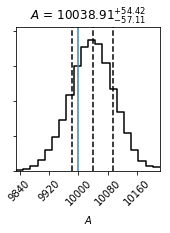

In [9]:
# MultiNest is a Bayesian inference tool, so we need to define a prior
A_Prior = [.5*A, 2.*A]

# Formatting the prior cube as required by MultiNest
theta_min = [A_Prior[0]]
theta_max = [A_Prior[1]]

theta_interval = list(np.array(theta_max) - np.array(theta_min))
n_params = len(theta_min) # number of parameters to fit for

def prior_cube(cube, ndim=1, nparams=1):
    """ Cube of priors - in the format required by MultiNest
    """

    for i in range(ndim):
        cube[i] = cube[i] * theta_interval[i] + theta_min[i]
    return cube

# Defining the likelihood function in terms of fixed and floated parameters
# Here we only float A
def LL_Multinest(theta, ndim = 1, nparams = 1):
    return scan.SHM_AnnualMod_ll(freqs, PSD_Data, ma, theta[0], v0_Halo, vDotMag_Halo,
                                 alpha_Halo, tbar_Halo, lambdaB, stacked_per_day)

# Run the MultiNest Scan
pymultinest.run(LL_Multinest, prior_cube, n_params,
                outputfiles_basename=chains_dir,
                n_live_points=nlive, **pymultinest_options)

# Plot the posteriors found by the MultiNest Scan
chain_file = chains_dir + 'post_equal_weights.dat'
chain = np.array(np.loadtxt(chain_file))[:, :-1]
# Now make a triangle plot using corner
corner.corner(chain, smooth=1.5, 
              labels = ['$A$'], truths = [A],
              smooth1d=1, quantiles=[0.16, 0.5, 0.84], show_titles=True,
              title_fmt='.2f', title_args={'fontsize': 14},
              range=[1 for _ in range(chain.shape[1])],
              plot_datapoints=False, verbose=False)
plt.show()

## Scan for the SHM parameter $\alpha$

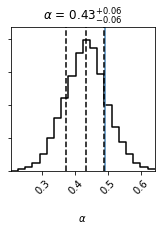

In [10]:
# Define the prior
alpha_Prior = [0.0, 1.0]

# Formatting the prior cube as required by MultiNest
theta_min = [alpha_Prior[0]]
theta_max = [alpha_Prior[1]]

theta_interval = list(np.array(theta_max) - np.array(theta_min))
n_params = len(theta_min) # number of parameters to fit for

def prior_cube(cube, ndim=1, nparams=1):
    """ Cube of priors - in the format required by MultiNest
    """

    for i in range(ndim):
        cube[i] = cube[i] * theta_interval[i] + theta_min[i]
    return cube

# Defining the likelihood function in terms of fixed and floated parameters
def LL_Multinest(theta, ndim = 1, nparams = 1):
    return scan.SHM_AnnualMod_ll(freqs, PSD_Data, ma, A, v0_Halo, vDotMag_Halo,
                                 theta[0], tbar_Halo, lambdaB, stacked_per_day)

# Run the MultiNest Scan
pymultinest.run(LL_Multinest, prior_cube, n_params,
                outputfiles_basename=chains_dir,
                n_live_points=nlive, **pymultinest_options)

# Plot the posteriors found by the MultiNest Scan
chain_file = chains_dir + 'post_equal_weights.dat'
chain = np.array(np.loadtxt(chain_file))[:, :-1]
# Now make a triangle plot using corner
corner.corner(chain, smooth=1.5, 
              labels = [r'$\alpha$'], truths = [alpha_Halo],
              smooth1d=1, quantiles=[0.16, 0.5, 0.84], show_titles=True,
              title_fmt='.2f', title_args={'fontsize': 14},
              range=[1 for _ in range(chain.shape[1])],
              plot_datapoints=False, verbose=False)

plt.show()

## Scan for the SHM parameter $\bar{t}$

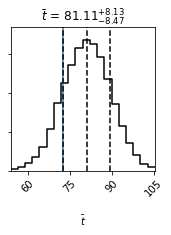

In [11]:
# Define the prior
tbar_Prior = [0, 365.0]

# Formatting the prior cube as required by MultiNest
theta_min = [tbar_Prior[0]]
theta_max = [tbar_Prior[1]]

theta_interval = list(np.array(theta_max) - np.array(theta_min))
n_params = len(theta_min) # number of parameters to fit for

def prior_cube(cube, ndim=1, nparams=1):
    """ Cube of priors - in the format required by MultiNest
    """

    for i in range(ndim):
        cube[i] = cube[i] * theta_interval[i] + theta_min[i]
    return cube

# Defining the likelihood function in terms of fixed and floated parameters
def LL_Multinest(theta, ndim = 1, nparams = 1):
    return scan.SHM_AnnualMod_ll(freqs, PSD_Data, ma, A, v0_Halo, vDotMag_Halo,
                                 alpha_Halo, theta[0], lambdaB, stacked_per_day)

# Run the MultiNest Scan
pymultinest.run(LL_Multinest, prior_cube, n_params,
                outputfiles_basename=chains_dir,
                n_live_points=nlive, **pymultinest_options)

# Plot the posteriors found by the MultiNest Scan
chain_file = chains_dir + 'post_equal_weights.dat'
chain = np.array(np.loadtxt(chain_file))[:, :-1]
# Now make a triangle plot using corner
corner.corner(chain, smooth=1.5, 
              labels = [r'$\bar{t}$'], truths = [tbar_Halo],
              smooth1d=1, quantiles=[0.16, 0.5, 0.84], show_titles=True,
              title_fmt='.2f', title_args={'fontsize': 14},
              range=[1 for _ in range(chain.shape[1])],
              plot_datapoints=False, verbose=False)

plt.show()

In each case we see we have been able to reasonably recover the injected parameters, demonstrating how we can pull these values out in the case of a detected signal. This can be extended to scanning over multiple parameters at once and also looking for the presence of substructure, as demonstrated in the associated paper.